In [2]:
import pandas as pd # For data manipulation
import pandas as pd # For data manipulation
import numpy as np # To perform different operations
import random
import matplotlib.pyplot as plt # For plotting and data visualization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #For splitting training data

In [3]:
#read csv files and create dataframes for each dataset
fruits_train_df = pd.read_csv('input/fruits-train.csv',sep=',')
fruits_test_df = pd.read_csv('input/fruits-test.csv',sep=',')
quality_train_df = pd.read_csv('input/quality-train.csv',sep=',')
quality_test_df = pd.read_csv('input/quality-test.csv',sep=',')

In [4]:
#Print the dataframes shapes
print("Fruits training dataset is of shape: ", fruits_train_df.shape,
     "\n\nFruits testing dataset is of shape: ", fruits_test_df.shape,
      "\n\nQuality training dataset is of shape: ", quality_train_df.shape,
      "\n\nQuality testing dataset is of shape: ", quality_test_df.shape)

Fruits training dataset is of shape:  (11787, 785) 

Fruits testing dataset is of shape:  (5067, 785) 

Quality training dataset is of shape:  (7628, 786) 

Quality testing dataset is of shape:  (3273, 786)


In [5]:
# Store data in numpy arrays
fruits_training = np.array(fruits_train_df, dtype = 'float32')
fruits_testing = np.array(fruits_test_df, dtype='float32')

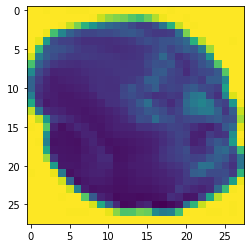

In [6]:
#Visualise a random fruit from the fruits training images
random_fruit = random.randint(1,11787)
plt.imshow( fruits_training[random_fruit,1:].reshape((28,28)) )